# Quora Insincere Questions Exploratory Data Analysis

We will begin exploring the training data in order to come up with insights and a plan for modeling.

In [1]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import nltk
import re

import string
from nltk.corpus import stopwords
from collections import Counter

# print any variable/statement on its own line (not just the last one!)
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

np.random.seed(27)

In [2]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [3]:
# load in data and print shape/head/tail
raw_data = pd.read_csv('../SUDHEER/train.csv')
print(raw_data.shape)
raw_data.head()

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


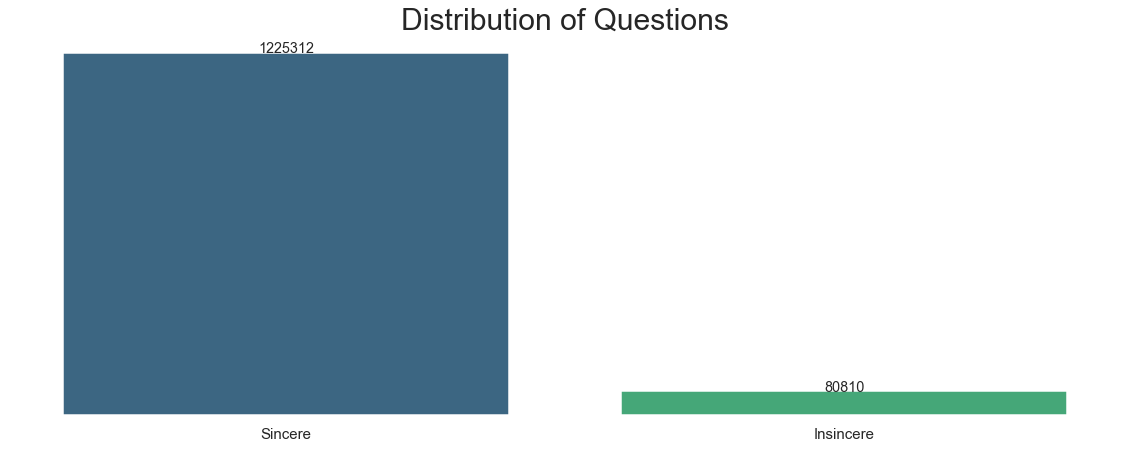

In [4]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(raw_data.target, palette='viridis')
g.set_xticklabels(['Sincere', 'Insincere'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Questions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
fig.savefig('classes.png')
plt.show()

In [5]:
# print percentage of questions where target == 1
(len(raw_data.loc[raw_data.target==1])) / (len(raw_data.loc[raw_data.target == 0])) * 100

6.595054973753624

### Class Imbalance
Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class.  With just 6.6% of our dataset belonging to the target class, we can definitely have an imbalanced class!

This is a problem because many machine learning models are designed to maximize overall accuracy, which especially with imbalanced classes may not be the best metric to use.  Classification accuracy is defined as the number of correct predictions divided by total predictions times 100.  For example, if we simply predicted that all questions are sincere, we would get a classification acuracy score of 93%!

This competition uses the F1 score which balances precision and recall.
 - Precision is the number of true positives divided by all positive predictions.  Precision is also called Positive Predictive Value.  It is a measure of a classifier's exactness.  Low precision indicates a high number of false positives.
 - Recall is the number of true positives divided by the number of positive values in the test data.  Recall is also called Sensitivity or the True Positive Rate.  It is a measure of a classifier's completeness.  Low recall indicates a high number of false negatives.

In [6]:
# printing out a random sample of questions labeled insincere
import random

index = random.sample(raw_data.index[raw_data.target == 1].tolist(), 5)
for i in index:
    print(raw_data.iloc[i, 1])

Why are most Finnish people so Islamaphobic?
Why don't libertarians see that "crony" capitalism is an inevitable aspect of capitalism?
Why don't supporters of gun rights organize a national system of financial support for victims of gun violence?
How did the Republican Party share it’s voter database with the Russians?
Could I chop off my hand and staple it back on and use it?


In [7]:
# taking a sample of the training data to speed up processing
df = raw_data.sample(frac=0.3)
df.shape

(391837, 3)

In [8]:
!pip install spacy

In [9]:
# tokenize with spacy
nlp = spacy.load('en')

df['tokens'] = [nlp(text, # disable parts of the language processing pipeline we don't need here to speed up processing
                    disable=['ner', # named entity recognition
                                   'tagger', # part-of-speech tagger
                                   'textcat', # document label categorizer
                                  ]) for text in df.question_text]
df.sample(5)

,qid,question_text,target,tokens
1259827,f6e443619a0c1fec7e31,Are all mental diseases on the same spectrum?,0,"(Are, all, mental, diseases, on, the, same, sp..."
486303,5f3d05b2c44df44a0bf7,What is the procedure to get a management PHD ...,0,"(What, is, the, procedure, to, get, a, managem..."
87500,11259a3b1e5b6f8468d9,How did Boeing redesign its airplane productio...,0,"(How, did, Boeing, redesign, its, airplane, pr..."
99551,137ec33ea540e8f8c123,How can we find the right oil seals online? Or...,0,"(How, can, we, find, the, right, oil, seals, o..."
63856,0c8744752bfd2ab06ddd,Do you have any regrets to tell?,0,"(Do, you, have, any, regrets, to, tell, ?)"


In [10]:
df['num_tokens'] = [len(token) for token in df.tokens]
df.sample(5)

,qid,question_text,target,tokens,num_tokens
1232251,f179a95cfc0d9c39dab9,Where can I find cheap mobile phones in Bangkok?,0,"(Where, can, I, find, cheap, mobile, phones, i...",10
641307,7d9c760d1173c645c8c0,Can psychopaths enjoy watching porn?,0,"(Can, psychopaths, enjoy, watching, porn, ?)",6
1026477,c92511e6c20c54d39db2,What is the cost price of maintenance dredging...,0,"(What, is, the, cost, price, of, maintenance, ...",11
403417,4f0bd82beb717872502b,Do phycopaths experience PTSD?,0,"(Do, phycopaths, experience, PTSD, ?)",5
1078465,d356f449702a9e789acc,How shall I check my pan card number through c...,0,"(How, shall, I, check, my, pan, card, number, ...",11


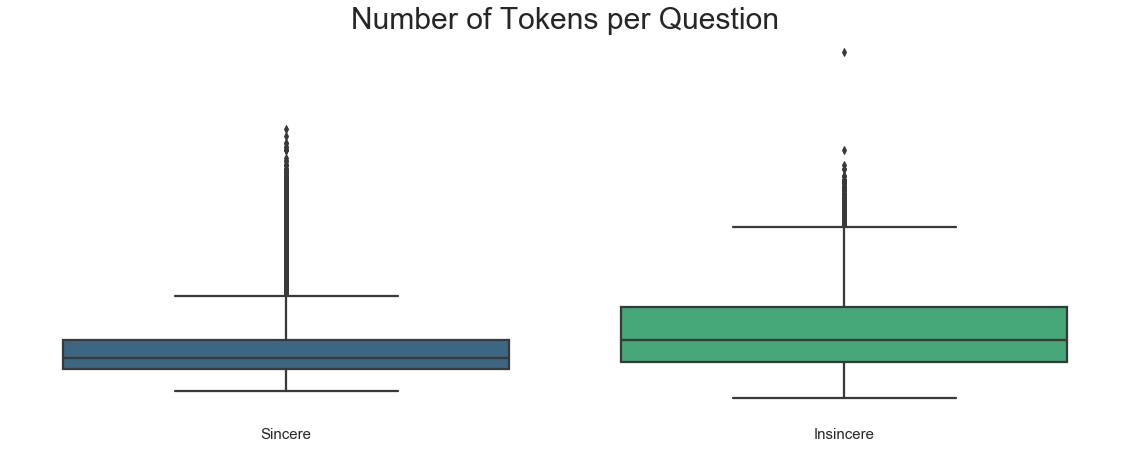

In [11]:
# using seaborns boxplot to visualize number of tokens per question
fig, ax = plt.subplots()
g = sns.boxplot(x=df.target, y=df.num_tokens, palette='viridis')
g.set_xticklabels(['Sincere', 'Insincere'])
g.set_yticklabels([])

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Tokens per Question', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
fig.savefig('tokens.png')
plt.show()

In [12]:
# get number of sentences per question
print(list(df.iloc[0,3].sents))

sents = [list(x.sents) for x in df.tokens]
df['num_sents'] = [len(sent) for sent in sents]
df.sample(5)

[How should HSEB student prepare for applying to US universities after their grade 12?]


,qid,question_text,target,tokens,num_tokens,num_sents
356894,45f5332baeff001f879a,Will my son become gay? He saw two guys kissin...,1,"(Will, my, son, become, gay, ?, He, saw, two, ...",19,3
1054866,ceb552509b2db6f3f616,How can a person or a business best prepare fo...,0,"(How, can, a, person, or, a, business, best, p...",26,2
636998,7cc2650187c481c21a94,If something is a possibility in the mind is i...,0,"(If, something, is, a, possibility, in, the, m...",15,1
1080700,d3c85895afb6a22495c7,How do I explain that liberalism is a mental d...,0,"(How, do, I, explain, that, liberalism, is, a,...",11,1
901106,b08f3eb4dc54d9d2f28f,Can any one tell me everything I need to know ...,0,"(Can, any, one, tell, me, everything, I, need,...",20,2


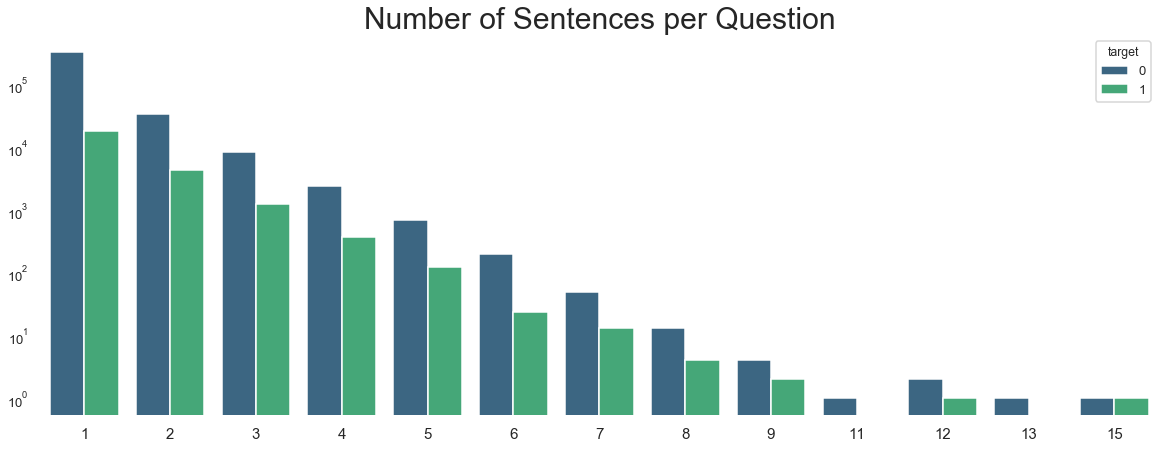

In [13]:
# plotting number of sentences per question
fig, ax = plt.subplots()
g = sns.countplot(df.num_sents, hue=df.target, palette='viridis')
#g.set_xticklabels(['Sincere', 'Insincere'])
g.set_yticklabels([])

# using log scale on y-axis so we can better see the questions with more sentences
ax.set(yscale='log')

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Number of Sentences per Question', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
fig.savefig('sentences.png')
plt.show()

In [14]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [15]:
from nltk.corpus import stopwords


In [16]:
# Finding most common words
# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
punctuations = string.punctuation
stopwords = set(stopwords.words('english'))
#stop_words = set(stopwords.words("english"))

def cleanup_text(docs):
    texts = []
    for doc in docs:
        doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
        doc = nlp(doc, disable=['ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [17]:
# Grab all text associated with insincere questions
insincere_text = [text for text in df[df['target'] == 1]['question_text']]
insincere_clean = cleanup_text(insincere_text)
insincere_clean = ' '.join(insincere_clean).split()

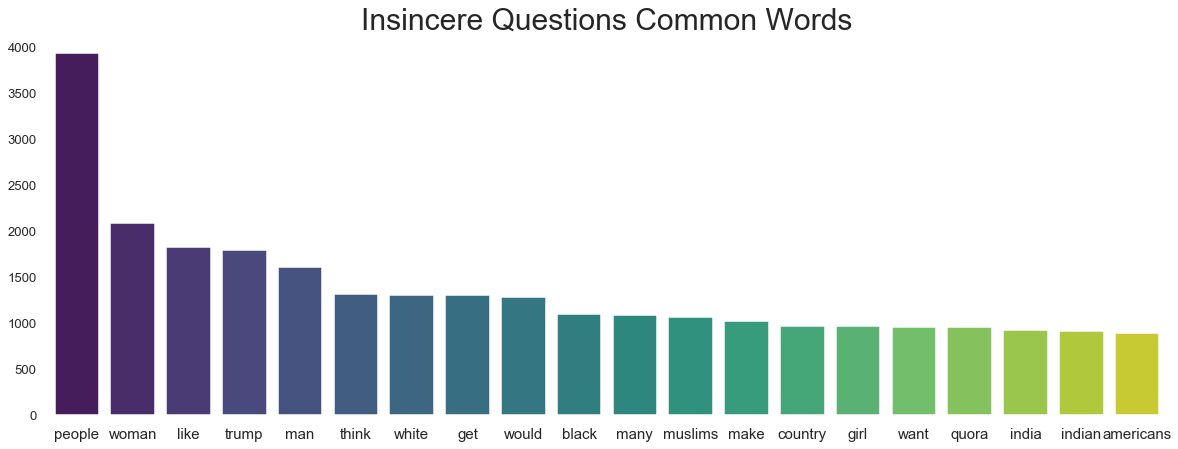

In [18]:
# Count all unique words
insincere_counts = Counter(insincere_clean)
# get words and word counts
insincere_common_words = [word[0] for word in insincere_counts.most_common(20)]
insincere_common_counts = [word[1] for word in insincere_counts.most_common(20)]

# plot 20 most common words in insincere questions
sns.barplot(insincere_common_words, insincere_common_counts, palette='viridis')
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Insincere Questions Common Words', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
fig.savefig('insincere_words.png')
plt.show()

In [24]:
# Grab all text associated with sincere questions
sincere_text = [text for text in df[df['target'] == 0]['question_text']]
sincere_clean = cleanup_text(sincere_text)
sincere_clean = ' '.join(sincere_clean).split()

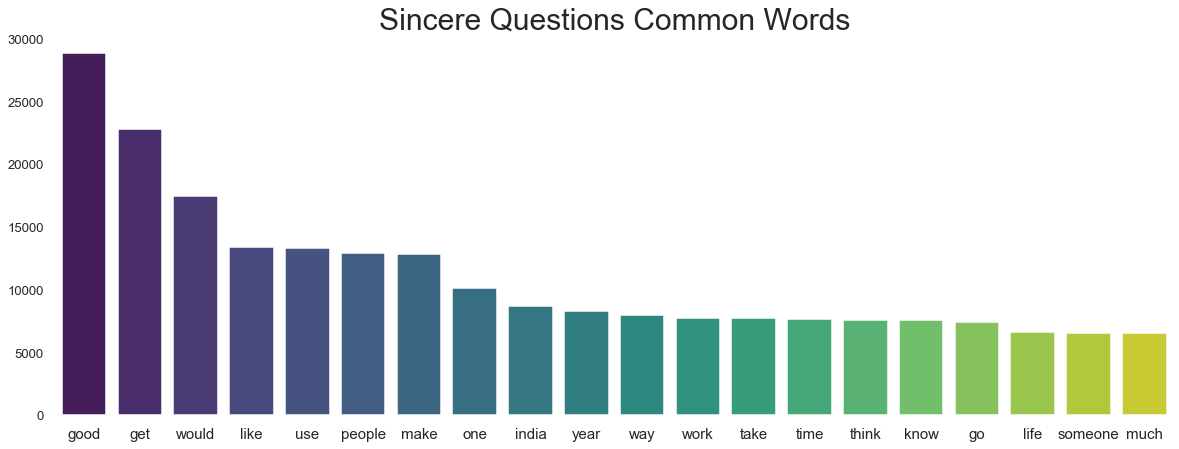

In [25]:
# Count all unique words
sincere_counts = Counter(sincere_clean)
# get words and word counts
sincere_common_words = [word[0] for word in sincere_counts.most_common(20)]
sincere_common_counts = [word[1] for word in sincere_counts.most_common(20)]

# plot 20 most common words in sincere questions
sns.barplot(sincere_common_words, sincere_common_counts, palette='viridis')
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Sincere Questions Common Words', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
fig.savefig('sincere.png')
plt.show()